In [321]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy
import math

%config InlineBackend.figure_formats = ['svg']

# Smith2020 / Superconducting circuit protected by two-Cooper-pair tunneling

# Part 1: Have a feeling about what's going on

The potential energy of a $\cos2\varphi$ element is 

\begin{align}
-E_J\cos2\varphi = - \frac{E_J}{2} \sum_{N=-\infty}^{\infty}|N\rangle\langle N+2| + |N+2\rangle\langle N|,
\end{align}

where $E_J$ is the effective tunneling energy of the process. This expression follows the from conjugation relation, $[\varphi, N]=i$, where $N$ is the number of Cooper pairs that have tunneled. The invariance of the potential under translations in $\varphi$ by multiples of $\pi$ implies that half-fluxons are able to traverse the element. 

Now. The total Hamiltonian reads

\begin{align}
H &= 4E_C(N-N_g)^2 - E_J\cos2\varphi,\\
&=4E_C\sum_{N=-\infty}^\infty(N-N_g)^2|N\rangle\langle N|- \frac{E_J}{2} \sum_{N=-\infty}^{\infty} |N\rangle\langle N+2| + |N+2\rangle\langle N|,
\end{align}

where $E_C$ is the charging energy and $N_g$ is the offset charge. 

Since the circuit element only allows *pairs of Cooper pairs to tunnel, the parity of the number of Cooper pairs that have tunneled is preserved under the action of the Hamiltonian. This leads to the ground state to be nearly-doubly degenerate. 

# Important notice

We now change the sign convention for the $\cos2\varphi$ element to positive, i.e. $E_J\cos2\varphi$.

## The Hamiltonian

In [322]:
def hamiltonian(Ec, Ej, N, ng):
    '''
        Hamiltonian for the cos2phi qubit
    '''
    m = np.diag(4 * Ec * (np.arange(-N, N + 1) - ng) ** 2) - 0.5 * Ej * (
        np.diag(np.ones(2 * N - 1), 2) + np.diag(np.ones(2 * N - 1), -2)
    )
    return qt.Qobj(m)

In [323]:
N0 = 6
H_2p = hamiltonian(Ec=1, Ej=50, N=N0, ng=0)

eig_val, eig_state = H_2p.eigenstates()

In [324]:
len(eig_val), 2*N0+1

(13, 13)

In [325]:
H_2p

Quantum object: dims=[[13], [13]], shape=(13, 13), type='oper', dtype=Dense, isherm=True
Qobj data =
[[144.   0. -25.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 100.   0. -25.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-25.   0.  64.   0. -25.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -25.   0.  36.   0. -25.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -25.   0.  16.   0. -25.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. -25.   0.   4.   0. -25.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -25.   0.   0.   0. -25.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -25.   0.   4.   0. -25.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. -25.   0.  16.   0. -25.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. -25.   0.  36.   0. -25.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -25.   0.  64.   0. -25.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. -25.   0. 100.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -25.   0. 144.]]

## Visualizing the Fock state coefficients

In [326]:
eig_state[0]

Quantum object: dims=[[13], [1]], shape=(13, 1), type='ket', dtype=Dense
Qobj data =
[[0.0179168 ]
 [0.        ]
 [0.12546548]
 [0.        ]
 [0.4591871 ]
 [0.        ]
 [0.73903262]
 [0.        ]
 [0.4591871 ]
 [0.        ]
 [0.12546548]
 [0.        ]
 [0.0179168 ]]

In [327]:
eig_state[1]

Quantum object: dims=[[13], [1]], shape=(13, 1), type='ket', dtype=Dense
Qobj data =
[[0.        ]
 [0.05013721]
 [0.        ]
 [0.26279379]
 [0.        ]
 [0.65454235]
 [0.        ]
 [0.65454235]
 [0.        ]
 [0.26279379]
 [0.        ]
 [0.05013721]
 [0.        ]]

In [328]:
for i in range(2*N0+1):
    print(eig_state[0][i][0])

(0.01791680407329419+0j)
0j
(0.12546547915862535+0j)
0j
(0.4591870990437971+0j)
0j
(0.7390326241013117+0j)
0j
(0.4591870990438021+0j)
0j
(0.12546547915862682+0j)
0j
(0.01791680407329437+0j)


For a truncated Hilbert space of dimension $2N_0+1$, straightforwardly speaking the number of charge on a superconducting island goes from $-N_0$ to $N_0$.

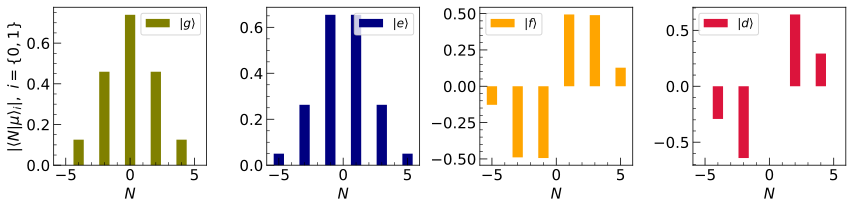

In [329]:
range_N = np.arange(-N0, N0+1)

def extract_coefficients(eig_state, N0, state_idx):
    # extract the float value of the coefficient
    return np.array([np.real(eig_state[state_idx][i][0]) for i in range(2 * N0 + 1)])

coefficients = [
    # extract the float value of the coefficient of the first 4 states
    extract_coefficients(eig_state, N0, i) for i in range(4)
]

shrink = 1
colors = ['olive', 'navy', 'orange', 'crimson']
labels = [r'$|g\rangle$', r'$|e\rangle$', r'$|f\rangle$', r'$|d\rangle$']

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))

for ax, coef, color, label in zip(axes, coefficients, colors, labels):
    ax.bar(range_N[shrink:-shrink], coef[shrink:-shrink], color=color, label=label)
    ax.set_xlabel(r'$N$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=7.5)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.legend(fontsize=12)

axes[0].set_ylabel(r'$|\langle N|\mu\rangle_i|,\ i=\{0,1\}$', fontsize=15)

fig.tight_layout()

*You can see that the $|g\rangle$ state has supports on only *even* Fock states, and the $|e\rangle$ state has supports on only *odd* Fock states. Same goes for the $|f\rangle$ and $|d\rangle$, respectively.

We said before that the Hamiltonian has two nearly degenerate ground states. These are $|g\rangle$ and $|e\rangle$. Their eigenenergies are

In [330]:
eig_val[0], eig_val[1]

(np.float64(-31.06676783059376), np.float64(-31.037310444688003))

Indeed, they are very close to each other. Let us actually look at the structure of the first 6 eigenenergies (adjust `ylim` to see others).

(-31.25, -31.0)

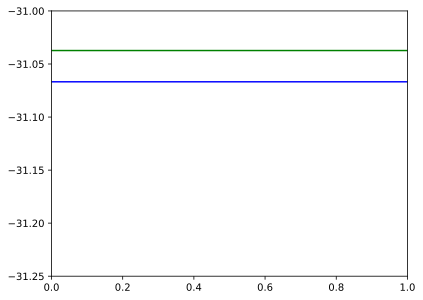

In [331]:
for i in range(6):
    plt.axhline(eig_val[i], label=f'{i}', color=list(mcolors.BASE_COLORS)[i])

plt.ylim([-31.25, -31])

In the Smith2020 paper, the states $|g\rangle$ and $|e\rangle$ are also called $|+\rangle$ and $|-\rangle$. They do not overlap in charge space (as seen above) and equivalently will have opposite periodicity in phase space (see below). This unique property predicts that for any sufficiently local operator $\mathcal{O}$, we have $\langle -|\mathcal{O}|+\rangle$. 

*We're gonna see later what these $\mathcal{O}$ operators are.

Furthermore, the states $|\circlearrowleft/\circlearrowright\rangle=\frac{1}{\sqrt{2}}(|+\rangle\pm|-\rangle)$ are, respectively, localized near $\varphi, \pi$. Let's now elucidate these concepts.

## Visualizing the states in the phase basis $|\varphi\rangle$

### Babyteeny maths

What we have from the diagonalization is

\begin{align}
|\psi\rangle = \sum_{N} \langle N|\psi\rangle |N\rangle.
\end{align}

Because the system has one DoF being continuous (superconducting phase) and one being discrete (number of Cooper pairs on a superconducting island), it is a rotor. The commutation relation is $[\varphi, N]=i$. We have the following identity,

\begin{align}
\langle \varphi | N \rangle = e^{iN\varphi}.
\end{align}

Now, the wavefunction of interest is 
\begin{align}
\langle \varphi | \psi \rangle &= \langle \varphi | \left(\sum_{N=-N_0}^{N_0} \langle N|\psi\rangle |N\rangle\right),\\
&=\sum_{N=-N_0}^{N_0} \langle N|\psi\rangle \langle \varphi | N\rangle,\\
&=\frac{1}{\sqrt{2\pi}}\sum_{N,N'}e^{i\varphi N'}\langle N' |N\rangle \langle N|\psi\rangle,\\
&=\frac{1}{\sqrt{2\pi}}\sum_{N}e^{i\varphi N}\langle N|\psi\rangle.
\end{align}

In [338]:
phi_grid_pts = 100
phi_basis_labels = np.linspace(-np.pi / 2, 3 * np.pi / 2, phi_grid_pts)

phi_wavefunc_amplitudes = [
    np.empty(phi_grid_pts, dtype=np.complex128) for _ in range(len(coefficients))
]

def compute_wavefunction_amplitudes(coef, phi_basis_labels, phi_grid_pts):
    return np.array([
        (1 / math.sqrt(2 * np.pi)) * np.sum(
            coef * np.exp(1j * phi_basis_labels[k] * range_N)
        ) for k in range(phi_grid_pts)
    ])

for i, coef in enumerate(coefficients):
    phi_wavefunc_amplitudes[i] = compute_wavefunction_amplitudes(coef, phi_basis_labels, phi_grid_pts)

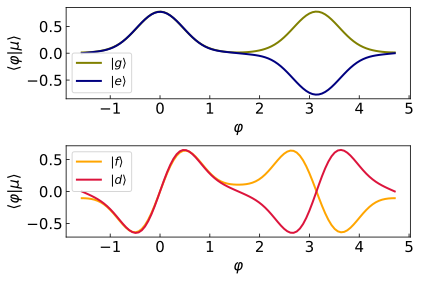

In [339]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 4))

axes[0].plot(phi_basis_labels, np.real(phi_wavefunc_amplitudes[0]), label=r'$|g\rangle$', color='olive', linewidth=2.0)
axes[0].plot(phi_basis_labels, np.real(phi_wavefunc_amplitudes[1]), label=r'$|e\rangle$', color='navy', linewidth=2.0)

axes[1].plot(phi_basis_labels, np.imag(phi_wavefunc_amplitudes[2]), label=r'$|f\rangle$', color='orange', linewidth=2.0)
axes[1].plot(phi_basis_labels, np.imag(phi_wavefunc_amplitudes[3]), label=r'$|d\rangle$', color='crimson', linewidth=2.0)

for ax in axes:
    ax.set_xlabel(r'$\varphi$', fontsize=15)
    ax.set_ylabel(r'$\langle\varphi|\mu\rangle$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.legend(fontsize=12)

fig.tight_layout()

We see that in this case, the wavefunctions are localized near $\phi=0,\pi$, resulting in a nearly degenerate harmonic level arrangement. We now look at the two specific states that we mentioned above, $|\circlearrowright/\circlearrowleft\rangle=\frac{1}{\sqrt{2}}(|+\rangle\pm|-\rangle)$.

In [340]:
ca_countercw = (1/np.sqrt(2))*(phi_wavefunc_amplitudes[0]+phi_wavefunc_amplitudes[1])
ca_counterctw = (1/np.sqrt(2))*(phi_wavefunc_amplitudes[0]-phi_wavefunc_amplitudes[1])

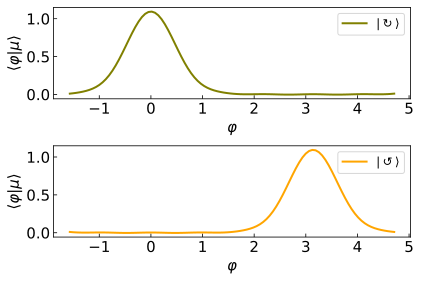

In [341]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 4))

axes[0].plot(phi_basis_labels, np.real(ca_countercw), label=r'$|\circlearrowright\rangle$', color='olive', linewidth=2.0)
axes[1].plot(phi_basis_labels, np.real(ca_counterctw), label=r'$|\circlearrowleft\rangle$', color='orange', linewidth=2.0)

for ax in axes:
    ax.set_xlabel(r'$\varphi$', fontsize=15)
    ax.set_ylabel(r'$\langle\varphi|\mu\rangle$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.legend(fontsize=12)

fig.tight_layout()

*Very cool, huh! These two states have suppresed overlap in phase space for large $E_J/E_C$. We could check this later if time permits. Right now, note that the $E_J/E_C$ value is 50.

## Check for the convergence of the Hilbert space

List of dimensions that we're gonna check

In [212]:
n_dimensions = [6, 7, 8, 9, 10, 11]

n_dimensions

[6, 7, 8, 9, 10, 11]

In [213]:
def qobj2np(state):
    ''' 
        Convert a Qobj state to a numpy array.
        Note: Fock coefficients assumed to be real.
    '''
    dim = state.shape[0]
    arr = []
    for d in range(dim):
        arr.append(np.real(state[d][0]))
    return np.array(arr)

In [214]:
def dilate(state_s, state_l):
    '''
        Dilate a state of dimension s to dimension l
    '''
    ns = state_s.shape[0]
    nl = state_l.shape[0]

    num_zeros = int((nl - ns)/2)

    state_s = qobj2np(state_s)

    dilated_state_s = np.array([0.0] * num_zeros + list(state_s) + [0.0] * num_zeros, dtype=float)
    
    return qt.Qobj(dilated_state_s)

In [215]:
H0 = hamiltonian(Ec=1, Ej=50, N=n_dimensions[0], ng=0)

_, eign_state_d0 = H0.eigenstates()

print(eign_state_d0[-1].shape)

H1 = hamiltonian(Ec=1, Ej=50, N=n_dimensions[1], ng=0)

_, eign_state_d1 = H1.eigenstates()

print(eign_state_d1[-1].shape)

(13, 1)
(15, 1)


In [216]:
def vis_n(state):
    ''' 
        Plot number distribution of a cos2phi state
    '''
    N0 = int((state.shape[0]-1)/2)
    range_N = np.arange(-N0, N0+1)
    coef = qobj2np(state)
    plt.bar(range_N, coef, color='olive')

In [217]:
def calculate_fidelities(n_dimensions, idx_state):
    fidelities = []
    eigprev = None

    for d in n_dimensions:
        if d == n_dimensions[0]:
            Hprev = hamiltonian(Ec=1, Ej=50, N=d, ng=0)
            _, eigprev = Hprev.eigenstates()
            continue

        Hnew = hamiltonian(Ec=1, Ej=50, N=d, ng=0)
        _, eignew = Hnew.eigenstates()

        fidelity = qt.fidelity(dilate(eigprev[idx_state], eignew[idx_state]), eignew[idx_state])
        fidelities.append(min(fidelity, 1.0))
        eigprev = eignew

    return fidelities

fidelities_0 = calculate_fidelities(n_dimensions, idx_state=0)
fidelities_1 = calculate_fidelities(n_dimensions, idx_state=1)
fidelities_2 = calculate_fidelities(n_dimensions, idx_state=2)
fidelities_3 = calculate_fidelities(n_dimensions, idx_state=3)
fidelities_4 = calculate_fidelities(n_dimensions, idx_state=4)

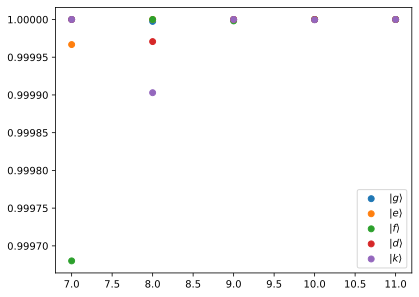

In [218]:
plt.scatter(n_dimensions[1:], fidelities_0, label=r'$|g\rangle$')
plt.scatter(n_dimensions[1:], fidelities_1, label=r'$|e\rangle$')
plt.scatter(n_dimensions[1:], fidelities_2, label=r'$|f\rangle$')
plt.scatter(n_dimensions[1:], fidelities_3, label=r'$|d\rangle$')
plt.scatter(n_dimensions[1:], fidelities_4, label=r'$|k\rangle$')
plt.legend()

*That's why we're having a zero fidelity here.

# Part 2. Decoherence estimate

We now consider a logical qubit formed by $|+\rangle$ and $|-\rangle$ states. These are now our logical $|\bar{0}\rangle$ and $|\bar{1}\rangle$. We try to elucidate which types of operators can and cannot induce transitions between the two states of the qubit.

Before going any further, we see that there's two operators that we need to think about. The first operator being Cooper-pair number operator $\hat{N}$. This operator is easily represented in the charge basis,
\begin{align}
\hat{N} = \sum_{N=-\infty}^{\infty} N|N\rangle\langle N|.
\end{align}
Representing the other one, superconducting phase operator $\hat{\varphi}$, in the charge basis is of a much more daunting task. We have several options. Let's explore them individually.

### Taking the logarithm

First, since we know how to represent $e^{i\hat\varphi}=\sum_{N}|N+1\rangle\langle N|$, we hope that we can actually find
\begin{align}
\log[e^{i\hat{\varphi}}] = \log[\sum_{-\infty}^{\infty}|N+1\rangle\langle N|]\rightarrow \hat{\varphi}=\frac{1}{i}\log[\sum_{-\infty}^{\infty}|N+1\rangle\langle N|]=\frac{1}{i}\log{M}.
\end{align}
The logarithm of the matrix ${M}=\sum_{-\infty}^{\infty}|N+1\rangle\langle N|$ actually can be found as follow. Assume that we can diagonalize it. Then let $D$ is the diagonal matrix,
\begin{align}
D = U^\dagger M U,\\
M = U D U^\dagger.
\end{align}
Hence,
\begin{align}
\log(M) &= \log(U D U^\dagger),\\
&=U \log(D) U^\dagger
\end{align}

In [219]:
M = np.diag(np.ones(2 * 6 - 1), -1)

eig_vals, eig_vecs = np.linalg.eig(M)

eig_vals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [220]:
M

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

Oh no! The matrix is not diagonalizable...

Perhaps it is because it's not really physical to have this sort of matrix? How about we imposing some periodic boundary conditions, like for example, for the last element of the sum, we actually translate the charge number back to the minimum number, that is 
\begin{align}
|N_{max}+1\rangle\langle N|\to |N_{min}\rangle\langle N_{max}+1|
\end{align}

In [221]:
M = np.diag(np.ones(2 * 6 - 1), -1)
M[0][-1] = 1

M

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [222]:
my_vec = np.zeros(M.shape[0])
my_vec[-1] = 1

my_vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [223]:
M@my_vec

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [224]:
eig_vals, eig_vecs = np.linalg.eig(M)

eig_vals

array([-1.00000000e+00+0.j       , -8.66025404e-01+0.5j      ,
       -8.66025404e-01-0.5j      , -5.00000000e-01+0.8660254j,
       -5.00000000e-01-0.8660254j, -1.11022302e-16+1.j       ,
       -1.11022302e-16-1.j       ,  5.00000000e-01+0.8660254j,
        5.00000000e-01-0.8660254j,  1.00000000e+00+0.j       ,
        8.66025404e-01+0.5j      ,  8.66025404e-01-0.5j      ])

In [225]:
D = np.diag(eig_vals)

In [226]:
Udagger = np.linalg.inv(eig_vecs)
U = eig_vecs

diagonalized_M = Udagger @ M @ U 

In [227]:
for i in range(D.shape[0]):
    print(D[i][i], np.round(diagonalized_M, 10)[i][i])

(-1.0000000000000009+0j) (-1-0j)
(-0.8660254037844397+0.5000000000000001j) (-0.8660254038+0.5j)
(-0.8660254037844397-0.5000000000000001j) (-0.8660254038-0.5j)
(-0.49999999999999983+0.8660254037844395j) (-0.5+0.8660254038j)
(-0.49999999999999983-0.8660254037844395j) (-0.5-0.8660254038j)
(-1.1102230246251565e-16+0.9999999999999996j) 1j
(-1.1102230246251565e-16-0.9999999999999996j) -1j
(0.5000000000000002+0.8660254037844392j) (0.5+0.8660254038j)
(0.5000000000000002-0.8660254037844392j) (0.5-0.8660254038j)
(0.9999999999999993+0j) (1+0j)
(0.8660254037844389+0.5000000000000002j) (0.8660254038+0.5j)
(0.8660254037844389-0.5000000000000002j) (0.8660254038-0.5j)


In [228]:
logD = np.diag(np.log(eig_vals))
log_M = U @ logD @ Udagger

log_M

array([[-1.90364976e-16+0.26179939j, -9.77048617e-01-0.26179939j,
         4.53449841e-01+0.26179939j, -2.61799388e-01-0.26179939j,
         1.51149947e-01+0.26179939j, -7.01489345e-02-0.26179939j,
        -1.38777878e-15+0.26179939j,  7.01489345e-02-0.26179939j,
        -1.51149947e-01+0.26179939j,  2.61799388e-01-0.26179939j,
        -4.53449841e-01+0.26179939j,  9.77048617e-01-0.26179939j],
       [ 9.77048617e-01-0.26179939j,  1.11022302e-15+0.26179939j,
        -9.77048617e-01-0.26179939j,  4.53449841e-01+0.26179939j,
        -2.61799388e-01-0.26179939j,  1.51149947e-01+0.26179939j,
        -7.01489345e-02-0.26179939j, -6.38378239e-16+0.26179939j,
         7.01489345e-02-0.26179939j, -1.51149947e-01+0.26179939j,
         2.61799388e-01-0.26179939j, -4.53449841e-01+0.26179939j],
       [-4.53449841e-01+0.26179939j,  9.77048617e-01-0.26179939j,
         2.10942375e-15+0.26179939j, -9.77048617e-01-0.26179939j,
         4.53449841e-01+0.26179939j, -2.61799388e-01-0.26179939j,
        

In [229]:
phi_charge_basis = -1j*log_M

phi_charge_basis

array([[ 0.26179939+1.90364976e-16j, -0.26179939+9.77048617e-01j,
         0.26179939-4.53449841e-01j, -0.26179939+2.61799388e-01j,
         0.26179939-1.51149947e-01j, -0.26179939+7.01489345e-02j,
         0.26179939+1.38777878e-15j, -0.26179939-7.01489345e-02j,
         0.26179939+1.51149947e-01j, -0.26179939-2.61799388e-01j,
         0.26179939+4.53449841e-01j, -0.26179939-9.77048617e-01j],
       [-0.26179939-9.77048617e-01j,  0.26179939-1.11022302e-15j,
        -0.26179939+9.77048617e-01j,  0.26179939-4.53449841e-01j,
        -0.26179939+2.61799388e-01j,  0.26179939-1.51149947e-01j,
        -0.26179939+7.01489345e-02j,  0.26179939+6.38378239e-16j,
        -0.26179939-7.01489345e-02j,  0.26179939+1.51149947e-01j,
        -0.26179939-2.61799388e-01j,  0.26179939+4.53449841e-01j],
       [ 0.26179939+4.53449841e-01j, -0.26179939-9.77048617e-01j,
         0.26179939-2.10942375e-15j, -0.26179939+9.77048617e-01j,
         0.26179939-4.53449841e-01j, -0.26179939+2.61799388e-01j,
        

In [230]:
qt.Qobj(phi_charge_basis).cosm()

Quantum object: dims=[[12], [12]], shape=(12, 12), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.44089210e-16  5.00000000e-01  5.55111512e-17 -5.50623635e-17
  -2.47911047e-16 -4.12028643e-18  3.72818067e-16 -6.42025096e-16
   2.35447136e-17  3.56068090e-16  9.75415794e-18  5.00000000e-01]
 [ 5.00000000e-01 -3.33066907e-16  5.00000000e-01 -1.13144968e-16
  -4.58388062e-17 -3.21825484e-16  3.31046620e-16  3.01056261e-16
  -9.30282554e-17  1.86948032e-16 -2.80999211e-16 -1.14414646e-16]
 [ 1.28945331e-16  5.00000000e-01  2.77555756e-16  5.00000000e-01
  -1.04875607e-16 -2.61935299e-16  2.32684165e-16 -3.77715919e-16
  -1.98836092e-16 -3.30493227e-17 -1.30201657e-16  7.25847414e-16]
 [-1.06077840e-16 -3.15926982e-16  5.00000000e-01  4.44089210e-16
   5.00000000e-01 -2.35922393e-16  1.02936419e-16 -1.56276305e-16
   4.16463667e-16 -1.90047550e-16 -5.98645548e-17 -2.88634738e-16]
 [ 1.34507010e-16  5.00019170e-16 -5.57421992e-16  5.00000000e-01
  -5.55111512e-17  5.00000000e-01  2.

#### Reconstruct the Hamiltonian in the charge basis using this operator

In [231]:
def build_H_c(Ec, N, ng):
    m = np.diag(4 * Ec * (np.arange(-N, N + 1) - ng) ** 2)
    return qt.Qobj(m)

rcs_N0_list = [6, 12, 24, 30]
rcs_eig_states_list = []
for N0 in rcs_N0_list:
    M = np.diag(np.ones(2 * N0), -1)
    M[0][-1] = 1

    eig_vals, eig_vecs = np.linalg.eig(M)
    Udagger = np.linalg.inv(eig_vecs)
    U = eig_vecs
    logD = np.diag(np.log(eig_vals))
    log_M = U @ logD @ Udagger
    phi_charge_basis = -1j*log_M
    phi_charge_basis = qt.Qobj(phi_charge_basis)
    H_j = - 50 * (2*phi_charge_basis).cosm()
    H_c = build_H_c(Ec=1, N=N0, ng=0)
    H_rcs = H_c+H_j
    _, rcs_eig_state = H_rcs.eigenstates()
    rcs_eig_states_list.append(rcs_eig_state)

In [232]:
rcs_eig_states_list[0][4]

Quantum object: dims=[[13], [1]], shape=(13, 1), type='ket', dtype=Dense
Qobj data =
[[-0.10029606]
 [-0.08207334]
 [-0.36941499]
 [-0.12471261]
 [-0.38051831]
 [ 0.059431  ]
 [ 0.6047442 ]
 [ 0.059431  ]
 [-0.38051831]
 [-0.12471261]
 [-0.36941499]
 [-0.08207334]
 [-0.10029606]]

In [233]:
def rcs_extract_coefficients(eig_state, N0, state_idx):
    # extract the float value of the coefficient
    return np.array([np.real(eig_state[state_idx][i][0]) for i in range(2 * N0 + 1)])

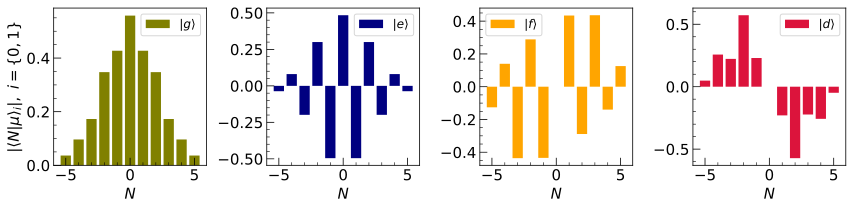

In [234]:
jdx = 0

rcs_eig_state = rcs_eig_states_list[jdx]
range_N = np.arange(-rcs_N0_list[jdx], rcs_N0_list[jdx]+1)
rcs_coefficients = [
    rcs_extract_coefficients(rcs_eig_state, rcs_N0_list[jdx], i) for i in range(4)
]

shrink = 1

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))

for ax, coef, color, label in zip(axes, rcs_coefficients, colors, labels):
    ax.bar(range_N[shrink:-shrink], coef[shrink:-shrink], color=color, label=label)
    ax.set_xlabel(r'$N$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=7.5)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.legend(fontsize=12)

axes[0].set_ylabel(r'$|\langle N|\mu\rangle_i|,\ i=\{0,1\}$', fontsize=15)

fig.tight_layout()

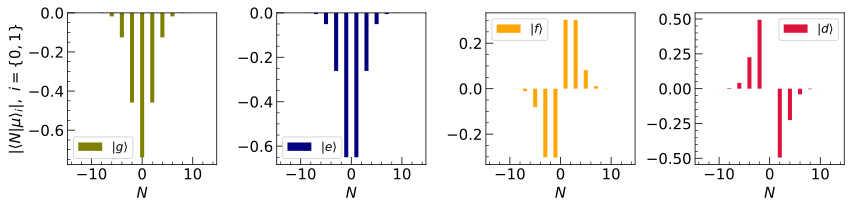

In [235]:
jdx = 3

rcs_eig_state = rcs_eig_states_list[jdx]
range_N = np.arange(-rcs_N0_list[jdx], rcs_N0_list[jdx]+1)
rcs_coefficients = [
    rcs_extract_coefficients(rcs_eig_state, rcs_N0_list[jdx], i) for i in range(4)
]

shrink = 17

fig, axes = plt.subplots(ncols=4, figsize=(12, 3))

for ax, coef, color, label in zip(axes, rcs_coefficients, colors, labels):
    ax.bar(range_N[shrink:-shrink], coef[shrink:-shrink], color=color, label=label)
    ax.set_xlabel(r'$N$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=7.5)
    ax.tick_params(axis='both', which='minor', length=3)
    ax.legend(fontsize=12)

axes[0].set_ylabel(r'$|\langle N|\mu\rangle_i|,\ i=\{0,1\}$', fontsize=15)

fig.tight_layout()

In [236]:
phi_grid_pts = 1000
phi_basis_labels = np.linspace(-np.pi / 2, 3 * np.pi / 2, phi_grid_pts)

rcs_phi_wavefunc_amplitudes = [
    np.empty(phi_grid_pts, dtype=np.complex128) for _ in range(len(rcs_coefficients))
]

for i, coef in enumerate(rcs_coefficients):
    rcs_phi_wavefunc_amplitudes[i] = compute_wavefunction_amplitudes(coef, phi_basis_labels, phi_grid_pts)

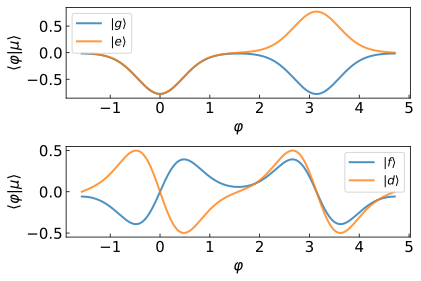

In [252]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 4))

axes[0].plot(phi_basis_labels, np.real(rcs_phi_wavefunc_amplitudes[0]), label=r'$|g\rangle$', linewidth=2.0, alpha=0.8)
axes[0].plot(phi_basis_labels, np.real(rcs_phi_wavefunc_amplitudes[1]), label=r'$|e\rangle$', linewidth=2.0, alpha=0.8)

axes[1].plot(phi_basis_labels, np.imag(rcs_phi_wavefunc_amplitudes[2]), label=r'$|f\rangle$', linewidth=2.0, alpha=0.8)
axes[1].plot(phi_basis_labels, np.imag(rcs_phi_wavefunc_amplitudes[3]), label=r'$|d\rangle$', linewidth=2.0, alpha=0.8)

for ax in axes:
    ax.set_xlabel(r'$\varphi$', fontsize=15)
    ax.set_ylabel(r'$\langle\varphi|\mu\rangle$', fontsize=15)
    ax.tick_params(axis='both', labelsize=15, direction='in', which='both')
    ax.legend(fontsize=12)

fig.tight_layout()

In [362]:
phi_val, phi_state = phi_charge_basis.eigenstates()

In [363]:
phi_state[0].dag()*phi_charge_basis*phi_state[0]

(-3.090091134678484-8.251006755771218e-16j)

In [372]:
coef_phi_state = []
for i in range(phi_state[0].shape[0]):
    coef_phi_state.append(np.exp(1j*i*phi_val[0]))
coef_phi_state = np.array(coef_phi_state)
coef_phi_state = (1/np.sqrt(2*np.pi))*coef_phi_state

In [378]:
1/np.sqrt(2*np.pi)

np.float64(0.3989422804014327)

In [376]:
coef_phi_state

array([ 0.39894228+0.j        , -0.39841332-0.02053705j,
        0.39682784+0.04101964j, -0.39419004-0.06139346j,
        0.39050692+0.08160447j, -0.38578825-0.10159908j,
        0.38004653+0.12132426j, -0.373297  -0.14072772j,
        0.36555756+0.15975799j, -0.35684872-0.17836462j,
        0.34719358+0.19649825j, -0.33661775-0.2141108j ,
        0.32514926+0.23115557j, -0.31281854-0.24758736j,
        0.29965829+0.26336259j, -0.28570339-0.27843943j,
        0.27099085+0.2927779j , -0.2555597 -0.30633998j,
        0.23945085+0.31908969j, -0.22270702-0.33099324j,
        0.20537261+0.34201905j, -0.18749359-0.35213789j,
        0.16911737+0.36132293j, -0.15029268-0.3695498j ,
        0.13106945+0.37679669j, -0.11149864-0.38304438j,
        0.09163215+0.38827631j, -0.07152267-0.3924786j ,
        0.05122353+0.39564011j, -0.03078855-0.39775245j,
        0.01027193+0.39881002j,  0.01027193-0.39881002j,
       -0.03078855+0.39775245j,  0.05122353-0.39564011j,
       -0.07152267+0.3924786j ,

In [373]:
real_part = []
imag_part = []
for i in range(phi_state.shape[0]):
    real_part.append(np.real((phi_charge_basis*phi_state[0])[i][0]))
    imag_part.append(np.imag((phi_charge_basis*phi_state[0])[i][0]))

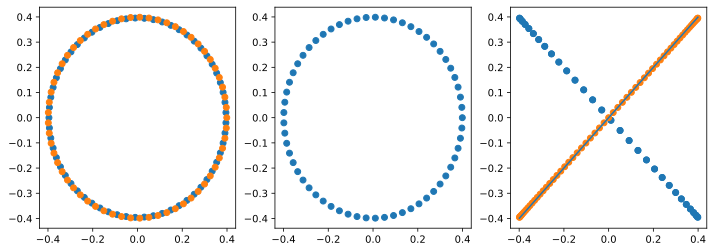

In [387]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
axes[0].scatter(real_part, imag_part)
axes[0].scatter(np.real(coef_phi_state), np.imag(coef_phi_state))
axes[1].scatter(np.real(coef_phi_state), np.imag(coef_phi_state))
axes[2].scatter(np.real(coef_phi_state), real_part)
axes[2].scatter(np.imag(coef_phi_state), imag_part)
axes[2].plot(np.linspace(-1/np.sqrt(np.pi*2), 1/np.sqrt(np.pi*2), 100), np.linspace(-1/np.sqrt(np.pi*2), 1/np.sqrt(2*np.pi), 100))

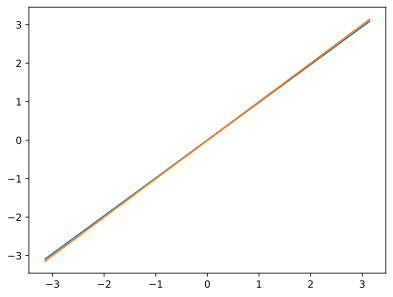

In [315]:
plt.plot(np.linspace(-np.pi, np.pi, 61), phi_val)
plt.plot(np.linspace(-np.pi, np.pi, 61), np.linspace(-np.pi, np.pi, 61))

In [342]:
N0 = 30
H_2p = hamiltonian(Ec=1, Ej=50, N=N0, ng=0)

eig_val, eig_state = H_2p.eigenstates()

In [343]:
inner_prod_0 = []

for i in range(eig_state.shape[0]):
    inner_prod_0.append(phi_state[i].dag()*eig_state[0])

inner_prod = np.array(inner_prod_0)

In [347]:
inner_prod_1 = []

for i in range(eig_state.shape[0]):
    inner_prod_1.append(eig_state[1].dag()*phi_state[i])

inner_prod = np.array(inner_prod_1)

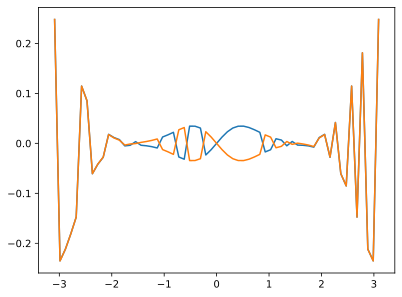

In [349]:
plt.plot(phi_val, np.imag(inner_prod_0))
plt.plot(phi_val, np.imag(inner_prod_1))

In [320]:
phi_state[i].dag()*eig_state[1]

(0.006386808164292638-0.24796924579933186j)

### Using $\sin\varphi$

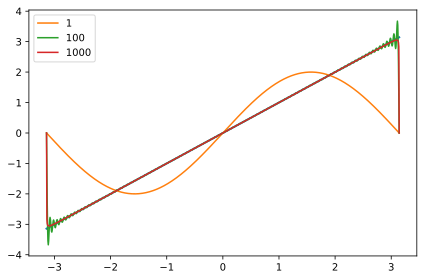

In [238]:
def fourier_series(x, terms):
    """Compute the Fourier series of f(x) = x with a given number of terms."""
    f_approx = np.zeros_like(x)
    for n in range(1, terms + 1):
        bn = 2 * (-1)**(n + 1) / n 
        f_approx += bn * np.sin(n * x)
    return f_approx

x = np.linspace(-np.pi, np.pi, 1000) 
f_original = x 
terms_list = [1, 100, 1000] 
approximations = [fourier_series(x, terms) for terms in terms_list]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, f_original, linewidth=2)

for terms, f_approx in zip(terms_list, approximations):
    ax.plot(x, f_approx, label=f'{terms}')
ax.legend()
fig.tight_layout()

This suggests we write the functional operator $f(\hat{\varphi})=\varphi$ on the interval $[-\pi,\pi]$ as
\begin{align}
\hat{\varphi}=\sum_{n=1}^\infty \frac{2(-1)^{n+1}}{n}\sin\left(n\hat{\varphi}\right)
\end{align}
Since we know how to write $\sin\left({n\hat{\varphi}}\right)$ in the charge basis, we can actually compute this sum:
\begin{align}
\sin\left({n\hat{\varphi}}\right)&=\frac{1}{2i}\left[\exp\left(i n\hat{\varphi}\right)-\exp\left(-i n\hat{\varphi}\right)\right],\\
&=\frac{1}{2i}\sum_{N=-\infty}^{\infty}|N+n\rangle\langle N|-|N\rangle\langle N+n|
\end{align}
Let's try to implement this...

In [239]:
def sin_op(n, N0):
    size = 2 * N0 - 1
    m = np.zeros((size, size), dtype=complex) 
    
    if n <= size:  
        diag_vals = (1 / (2 * 1j))
        np.fill_diagonal(m[n:], diag_vals)      
        np.fill_diagonal(m[:, n:], -diag_vals)  
    
    else:
        print("Warning: n > mat_size")
        
    return m

def cos_op(n, N0):
    size = 2 * N0 - 1
    m = np.zeros((size,size), dtype=complex)

    if n < size:
        diag_vals = (1/2)
        np.fill_diagonal(m[n:], diag_vals)
        np.fill_diagonal(m[:, n:], diag_vals)
    
    if n >= size:
        print("Warning: n >= mat_size")
    
    return m

def coef_fourier(n):
    return (2 * (-1) ** (n + 1) / n)

N0 = 500
mat_size = 2 * N0 - 1
varphi = np.zeros((mat_size, mat_size), dtype=complex)
coefs = []
num_terms = 999
for n in range(1, num_terms+1):  
    coefs.append(coef_fourier(n))
    varphi += coef_fourier(n) * sin_op(n, N0)
    
varphi = qt.Qobj(varphi)

In [240]:
varphi

Quantum object: dims=[[999], [999]], shape=(999, 999), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+0.j         0.+1.j         0.-0.5j        ... 0.-0.00100402j
  0.+0.00100301j 0.-0.001002j  ]
 [0.-1.j         0.+0.j         0.+1.j         ... 0.+0.00100503j
  0.-0.00100402j 0.+0.00100301j]
 [0.+0.5j        0.-1.j         0.+0.j         ... 0.-0.00100604j
  0.+0.00100503j 0.-0.00100402j]
 ...
 [0.+0.00100402j 0.-0.00100503j 0.+0.00100604j ... 0.+0.j
  0.+1.j         0.-0.5j       ]
 [0.-0.00100301j 0.+0.00100402j 0.-0.00100503j ... 0.-1.j
  0.+0.j         0.+1.j        ]
 [0.+0.001002j   0.-0.00100301j 0.+0.00100402j ... 0.+0.5j
  0.-1.j         0.+0.j        ]]

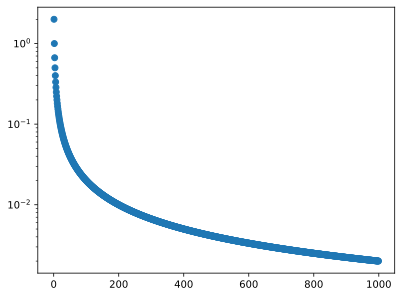

In [241]:
plt.scatter(range(1, num_terms+1), np.abs(coefs))
plt.yscale('log')

In [242]:
mord_cos2p = (2*varphi).cosm()

why
why
why


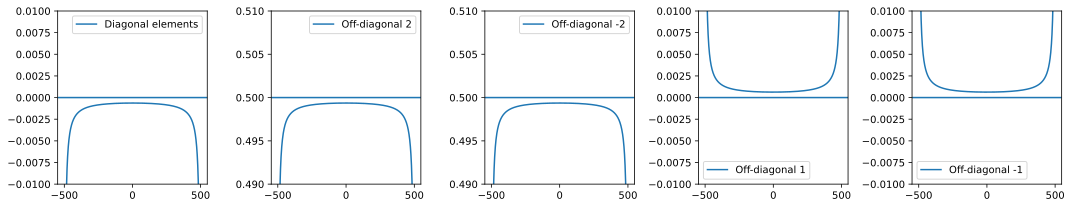

In [244]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 3))

axes[0].plot(np.arange(-(N0-1), N0, 1), np.real(np.diagonal(mord_cos2p.full())), label='Diagonal elements')
axes[1].plot(np.arange(-(N0-2), (N0-1), 1), np.real(np.diagonal(mord_cos2p.full(), offset=2)), label='Off-diagonal 2')
axes[2].plot(np.arange(-(N0-2), (N0-1), 1), np.real(np.diagonal(mord_cos2p.full(), offset=-2)), label='Off-diagonal -2')
axes[3].plot(np.arange(-N0+1, N0-1, 1), np.real(np.diagonal(mord_cos2p.full(), offset=1)), label='Off-diagonal 1')
axes[4].plot(np.arange(-N0+1, N0-1, 1), np.real(np.diagonal(mord_cos2p.full(), offset=-1)), label='Off-diagonal -1')

for i in range(5):
    axes[i].legend()
    if i == 0 or i == 3 or i == 4:
        print('why')
        axes[i].set_ylim([-0.01, 0.01])
        axes[i].axhline(0)
    if i == 1 or i == 2:
        axes[i].set_ylim([0.49, 0.51])
        axes[i].axhline(0.5)

fig.tight_layout()